## **3_Model_Training_and_Selection.ipynb**

In [13]:
DATA_DIR = "/content/drive/MyDrive/Project/healthcare/"


In [49]:
# ⚙️ Setup for advanced modeling
!pip install xgboost lightgbm catboost --quiet

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 📥 Load preprocessed + feature-selected data
data_path = "/content/drive/MyDrive/Project/healthcare/Xy_selected_top30.csv"
df = pd.read_csv(data_path)

# 🎯 Features and Target
X = df.drop(columns=["PotentialFraud"])
y = df["PotentialFraud"]

# 🔀 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# 📏 Standardize only numeric columns
num_cols = X.select_dtypes(include=np.number).columns.tolist()

scaler = ColumnTransformer([
    ("scale", StandardScaler(), num_cols)
], remainder="passthrough")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [ ]:
# ⚠️ Use same selected columns from feature selection
selected_features = X_train.columns.tolist()

# 🧪 Select same features in test data
X_test_selected = X_test[selected_features]

# 💾 Save to CSV
X_test_selected.to_csv("/content/drive/MyDrive/Project/healthcare/test_selected.csv", index=False)

print("✅ Test set with selected features saved.")


📊 Model: Logistic Regression (CV)
📈 Mean F1 Score (CV): 0.4469 ± 0.0021
📄 Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.63      0.64     86354
           1       0.44      0.46      0.45     53199

    accuracy                           0.57    139553
   macro avg       0.55      0.55      0.55    139553
weighted avg       0.57      0.57      0.57    139553

✅ F1 Score: 0.4477
✅ ROC AUC:  0.5708


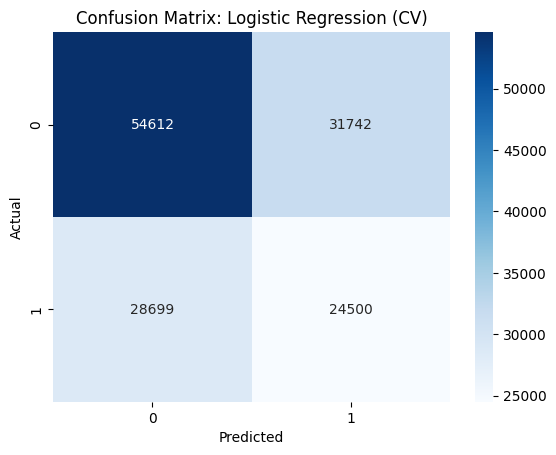

In [50]:
# Baseline Logistic Regression + Reusable Evaluation Function

from sklearn.model_selection import cross_val_predict

# 🔁 Reusable evaluation function
def evaluate_model(name, model, X_train, y_train, X_test, y_test, do_cv=True):
    print(f"\n📊 Model: {name}")

    if do_cv:
        # 🔁 Stratified 5-Fold Cross-Validation (F1 Macro)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
        print(f"📈 Mean F1 Score (CV): {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

    # 🧠 Fit and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # 📋 Classification report
    print("📄 Classification Report:")
    print(classification_report(y_test, y_pred))

    # 📉 ROC AUC and F1
    print(f"✅ F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"✅ ROC AUC:  {roc_auc_score(y_test, y_prob):.4f}")

    # 🧱 Confusion Matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

# 🚀 Logistic Regression Pipeline
pipe_lr = Pipeline([
    ('scale', scaler),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

evaluate_model("Logistic Regression (CV)", pipe_lr, X_train, y_train, X_test, y_test)



📊 Model: Random Forest (Tuned)
📈 Mean F1 Score (CV): 0.6458 ± 0.0049
📄 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80     86354
           1       0.68      0.60      0.64     53199

    accuracy                           0.74    139553
   macro avg       0.72      0.71      0.72    139553
weighted avg       0.73      0.74      0.74    139553

✅ F1 Score: 0.6354
✅ ROC AUC:  0.7939


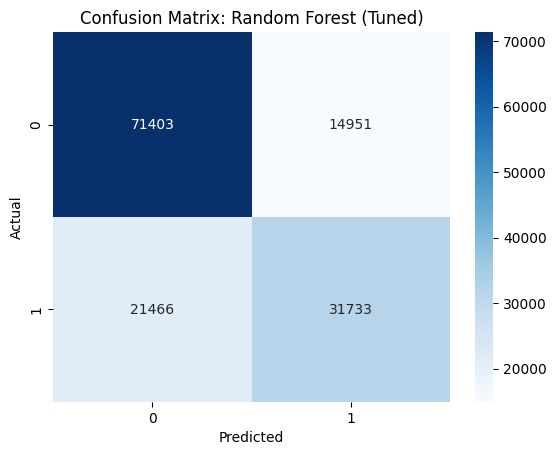

In [53]:
# 🌲 Random Forest with class balancing and parallelism
pipe_rf = Pipeline([
    ('scale', scaler),
    ('clf', RandomForestClassifier(
        n_estimators=150,
        max_depth=12,
        min_samples_split=10,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    ))
])

evaluate_model("Random Forest (Tuned)", pipe_rf, X_train, y_train, X_test, y_test)


📊 Model: Random Forest (Small Subset)
📄 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78     86354
           1       0.64      0.56      0.60     53199

    accuracy                           0.71    139553
   macro avg       0.70      0.68      0.69    139553
weighted avg       0.71      0.71      0.71    139553

✅ F1 Score: 0.5983
✅ ROC AUC:  0.7589


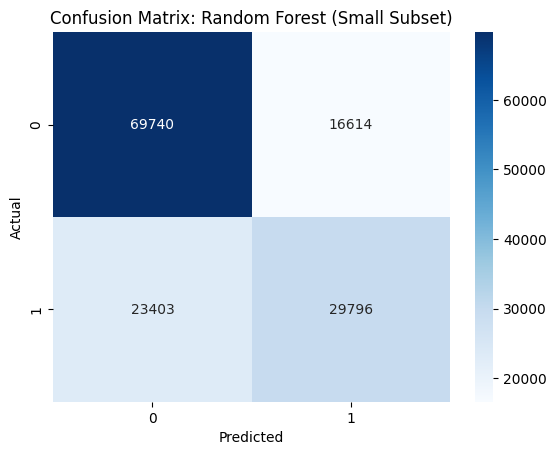

In [52]:
# 🔄 Try on a sample subset for quicker results
X_sample = X_train.sample(100_000, random_state=42)
y_sample = y_train.loc[X_sample.index]

pipe_rf_small = Pipeline([
    ('scale', scaler),
    ('clf', RandomForestClassifier(
        n_estimators=100,  # cut to 100 trees
        max_depth=10,
        min_samples_split=10,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    ))
])

evaluate_model("Random Forest (Small Subset)", pipe_rf_small, X_sample, y_sample, X_test, y_test, do_cv=False)


📄 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     86354
           1       0.88      0.78      0.83     53199

    accuracy                           0.88    139553
   macro avg       0.88      0.86      0.87    139553
weighted avg       0.88      0.88      0.88    139553

✅ F1 Score: 0.8299
✅ ROC AUC:  0.9426


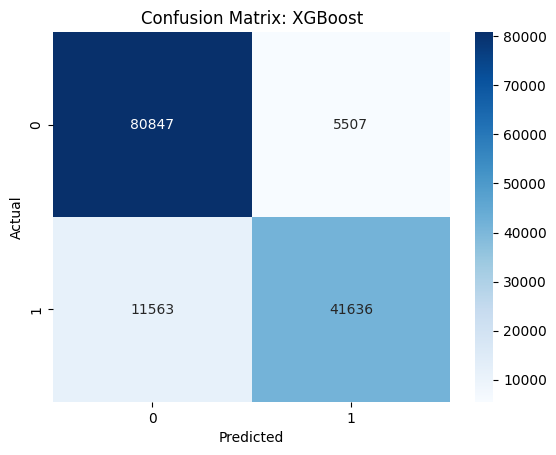

In [56]:
# XGBoost Classifier with Early Stopping
import xgboost as xgb

# 📦 Convert to DMatrix
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# ⚙️ Training parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "seed": 42
}

# 📚 Train with early stopping
xgb_final = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dvalid, "validation")],
    early_stopping_rounds=20,
    verbose_eval=False
)

# 🧠 Predict
y_pred = (xgb_final.predict(dtest) > 0.5).astype(int)
y_prob = xgb_final.predict(dtest)

# 🧪 Evaluate
print("📄 Classification Report:")
print(classification_report(y_test, y_pred))

print(f"✅ F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"✅ ROC AUC:  {roc_auc_score(y_test, y_prob):.4f}")

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

[LightGBM] [Info] Number of positive: 159597, number of negative: 259061
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5471
[LightGBM] [Info] Number of data points in the train set: 418658, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.381211 -> initscore=-0.484412
[LightGBM] [Info] Start training from score -0.484412
📄 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     86354
           1       0.87      0.80      0.83     53199

    accuracy                           0.88    139553
   macro avg       0.88      0.86      0.87    139553
weighted avg       0.88      0.88      0.88    139553

✅ F1 Score: 0.8327
✅ ROC AUC:  0.9434


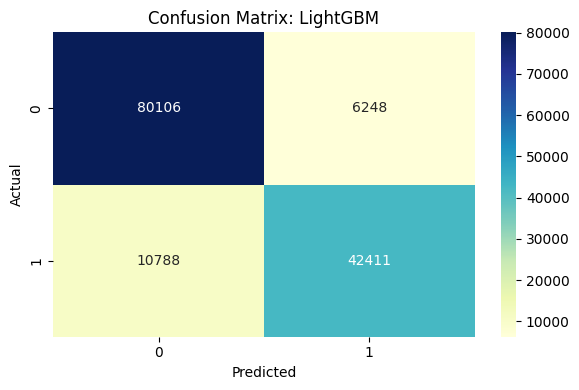

In [59]:
# LightGBM Model Training and Evaluation

from lightgbm import LGBMClassifier

# 🧠 Initialize the LightGBM model
lgb_clf = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 📤 Train the model
lgb_clf.fit(X_train, y_train)

# 🔍 Predictions
y_pred_lgb = lgb_clf.predict(X_test)
y_prob_lgb = lgb_clf.predict_proba(X_test)[:, 1]

# 📊 Evaluation
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("📄 Classification Report:")
print(classification_report(y_test, y_pred_lgb))

print(f"✅ F1 Score: {f1_score(y_test, y_pred_lgb):.4f}")
print(f"✅ ROC AUC:  {roc_auc_score(y_test, y_prob_lgb):.4f}")

# 🔷 Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_lgb), annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix: LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
import joblib
import os

# 🔖 Path setup
model_save_path = "/content/drive/MyDrive/Project/healthcare/models/"
os.makedirs(model_save_path, exist_ok=True)

# 💾 Save model
joblib.dump(lgb_clf, os.path.join(model_save_path, "lightgbm_model.pkl"))

# 💾 Save selected features
with open(os.path.join(model_save_path, "selected_features.txt"), "w") as f:
    for col in X_train.columns:
        f.write(col + "\n")

print("✅ LightGBM model and features saved.")

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     86354
           1       0.86      0.71      0.78     53199

    accuracy                           0.85    139553
   macro avg       0.85      0.82      0.83    139553
weighted avg       0.85      0.85      0.84    139553

✅ F1 Score: 0.7807
✅ ROC AUC:  0.9156


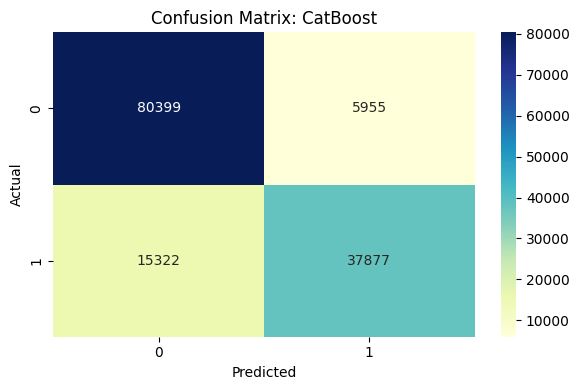

In [60]:
# CatBoost – Training and Evaluation Code (Handles Categorical Data Well)
!pip install catboost --quiet

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Initialize CatBoost model
cat_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=0  # Suppress training output
)

# 🔁 Train the model
cat_model.fit(X_train, y_train)

# 🔍 Predict
y_pred_cat = cat_model.predict(X_test)
y_prob_cat = cat_model.predict_proba(X_test)[:, 1]

# 📊 Evaluation
print("📄 Classification Report:")
print(classification_report(y_test, y_pred_cat))

print(f"✅ F1 Score: {f1_score(y_test, y_pred_cat):.4f}")
print(f"✅ ROC AUC:  {roc_auc_score(y_test, y_prob_cat):.4f}")

# 📌 Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_cat), annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix: CatBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


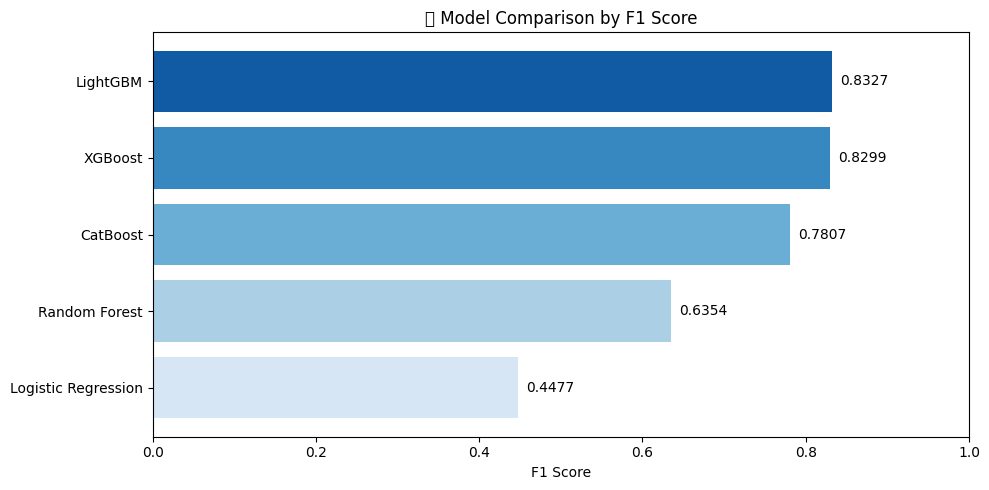

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Model metrics
model_metrics = {
    "Logistic Regression": {"F1": 0.4477, "ROC AUC": 0.5708},
    "Random Forest": {"F1": 0.6354, "ROC AUC": 0.7939},
    "XGBoost": {"F1": 0.8299, "ROC AUC": 0.9426},
    "LightGBM": {"F1": 0.8327, "ROC AUC": 0.9434},
    "CatBoost": {"F1": 0.7807, "ROC AUC": 0.9156},
}

metrics_df = pd.DataFrame(model_metrics).T.reset_index().rename(columns={"index": "Model"})

# Sort by F1 score
f1_sorted = metrics_df.sort_values("F1", ascending=True)
colors = sns.color_palette("Blues", len(f1_sorted))  # light to dark

# Map score order to colors
f1_sorted["Color"] = colors
f1_sorted = f1_sorted.sort_values("F1", ascending=False)

plt.figure(figsize=(10, 5))
bars = plt.barh(f1_sorted["Model"], f1_sorted["F1"], color=f1_sorted["Color"])
plt.xlabel("F1 Score")
plt.title("📊 Model Comparison by F1 Score")

# Annotate scores
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.4f}", va='center', fontsize=10)

plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 📊 F1 Score Comparison
F1 Score balances precision and recall, making it ideal for imbalanced datasets like fraud detection.

- LightGBM and XGBoost outperform others, closely followed by CatBoost.

- Logistic Regression performs the worst, indicating it's too simple for this problem.



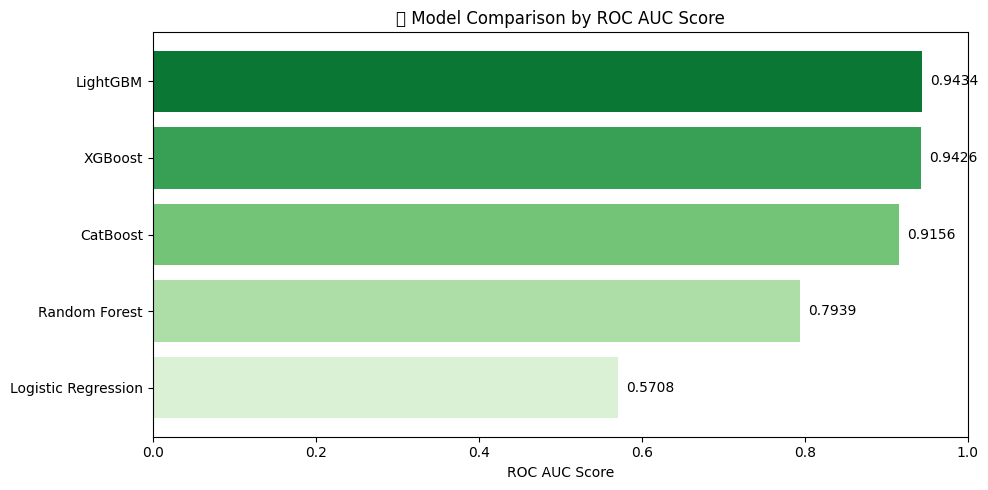

In [65]:
# 📈 ROC AUC Score Comparison — Darkest Green = Best
# Sort by ROC AUC
auc_sorted = metrics_df.sort_values("ROC AUC", ascending=True)
colors = sns.color_palette("Greens", len(auc_sorted))  # light to dark

# Map score order to colors
auc_sorted["Color"] = colors
auc_sorted = auc_sorted.sort_values("ROC AUC", ascending=False)

plt.figure(figsize=(10, 5))
bars = plt.barh(auc_sorted["Model"], auc_sorted["ROC AUC"], color=auc_sorted["Color"])
plt.xlabel("ROC AUC Score")
plt.title("📈 Model Comparison by ROC AUC Score")

# Annotate scores
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.4f}", va='center', fontsize=10)

plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### 📈 ROC AUC Comparison
ROC AUC quantifies how well the model can distinguish between classes across thresholds.

- LightGBM (0.9434) and XGBoost (0.9426) are nearly perfect in classification.

- CatBoost (0.9156) is also highly effective.

- The gradient in the bar color represents performance, with the darkest bars indicating the best models.

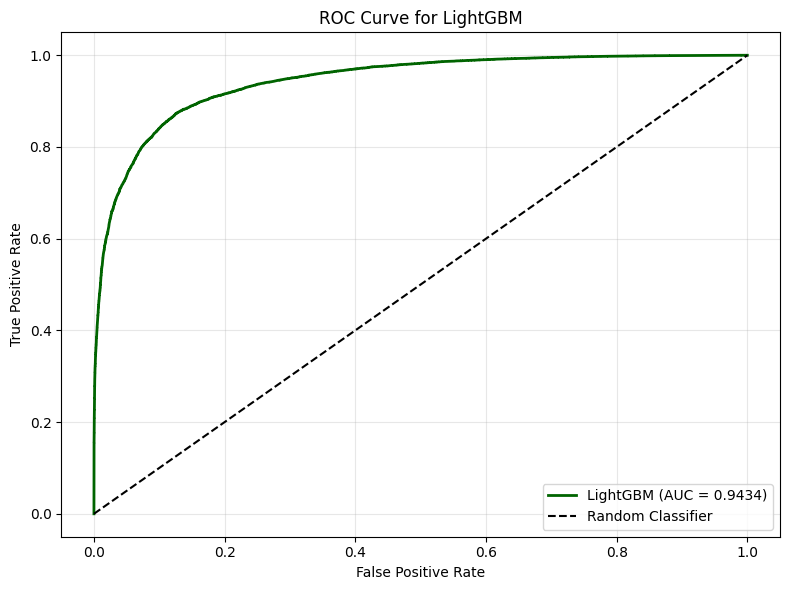

In [67]:
# ROC Curve for LightGBM

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 🎯 Generate prediction probabilities for LightGBM
y_pred_prob = lgb_clf.predict_proba(X_test)[:, 1]

# 🎯 Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 📈 Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"LightGBM (AUC = {roc_auc:.4f})", color='darkgreen', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LightGBM")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### ROC Curve
Evaluates how well LightGBM separates fraud vs non-fraud.
- A curve closer to the top-left means better classification performance.

- The AUC (Area Under Curve) of 0.94+ confirms excellent model discrimination.



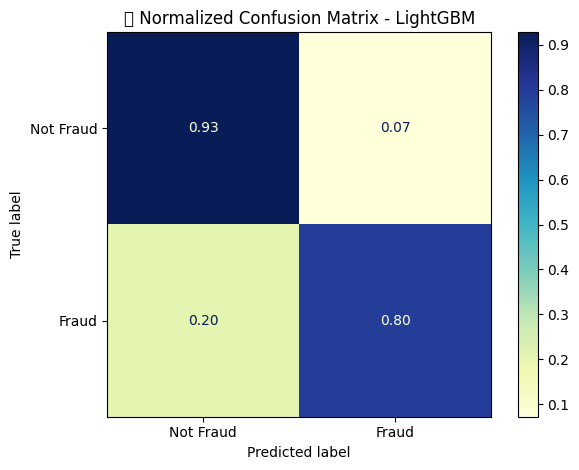

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 📊 Predict classes
y_pred_class = lgb_clf.predict(X_test)

# 🎯 Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_class, normalize='true')

# 📉 Plot normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='YlGnBu', values_format=".2f")
plt.title(" Normalized Confusion Matrix - LightGBM")
plt.grid(False)
plt.tight_layout()
plt.show()


### 🔍 Normalized Confusion Matrix - LightGBM

- How well the model performs across both classes.
- Useful to check class imbalance impact and recall on fraud class.
  
  🔹 93% of non-fraud cases are correctly classified.

  🔹 80% of fraud cases are caught — this is very high recall for fraud.

  🔸 Only 7% of non-fraud cases are wrongly flagged as fraud — low false positives.

  🔸 20% of fraud is missed — could be improved further using threshold tuning or recall optimization.



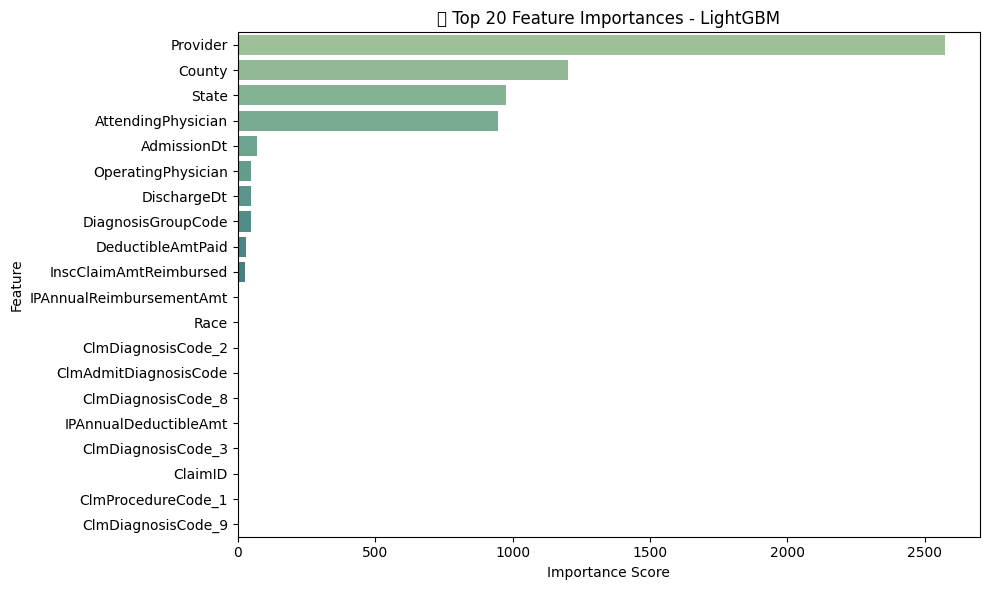

In [69]:
# Feature Importance (LightGBM - Top 20)

import numpy as np

# 🔍 Get feature importances from LightGBM
importances = lgb_clf.feature_importances_
features = X_train.columns

# 📊 Create DataFrame
feat_imp_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(20)

# 📉 Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df, palette="crest")
plt.title("Top 20 Feature Importances - LightGBM")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Feature Importance (LightGBM - Top 20)

- Identifies which features drive fraud prediction the most.

- Enables business teams to investigate top contributing factors.

- Useful for audit, explainability, and compliance.

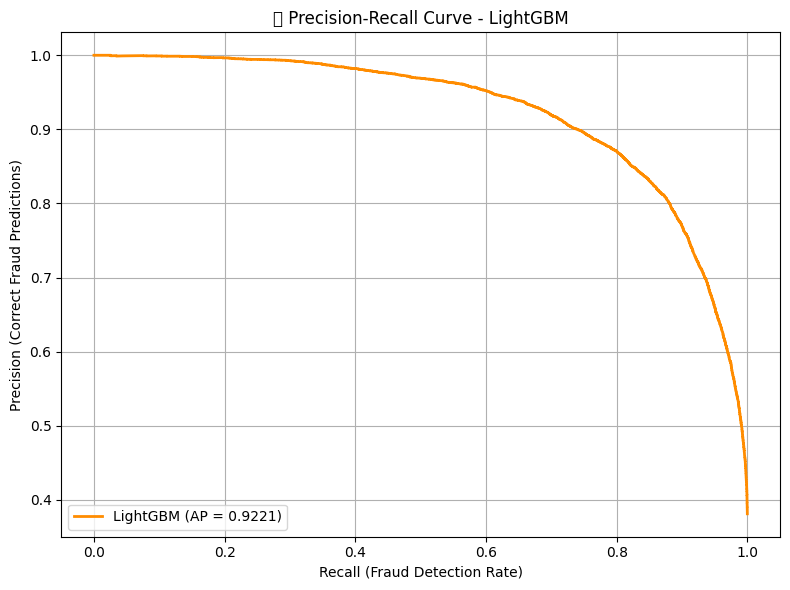

In [70]:
# Precision-Recall Curve for LightGBM

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 🎯 Get predicted probabilities from LightGBM
y_scores = lgb_clf.predict_proba(X_test)[:, 1]

# 🔍 Compute Precision-Recall pairs
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

# 📊 Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"LightGBM (AP = {avg_precision:.4f})", color="darkorange", linewidth=2)
plt.xlabel("Recall (Fraud Detection Rate)")
plt.ylabel("Precision (Correct Fraud Predictions)")
plt.title("📉 Precision-Recall Curve - LightGBM")
plt.grid(True)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


### Precision-Recall Curve for LightGBM
- Unlike ROC, PR is better for imbalanced datasets like fraud detection.

- High area under PR curve means fewer false alarms and missed frauds.

- This plot highlights the model’s ability to catch fraud while minimizing wasted investigations.

In [71]:
# Force reinstall SHAP to avoid broken dependencies
!pip install --upgrade --force-reinstall shap --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 

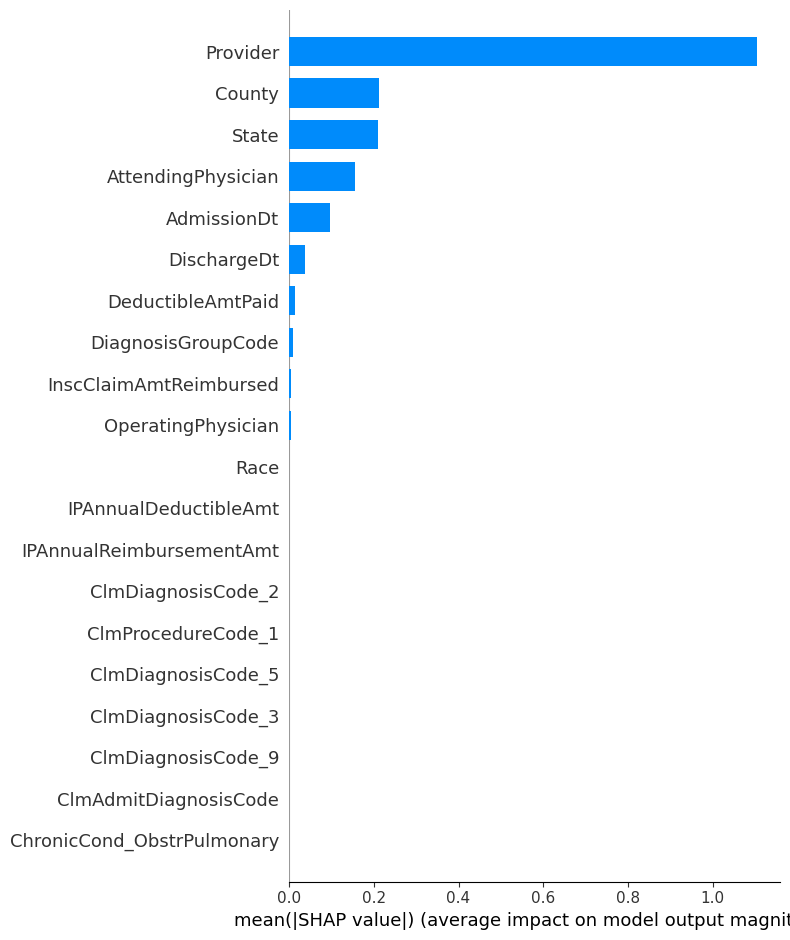

In [72]:
import shap

# 💡 Initialize SHAP explainer for LightGBM model
explainer = shap.TreeExplainer(lgb_clf)

# 📤 Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# 📈 Plot SHAP summary
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)


### SHAP Summary Plot (Global Feature Impact)
- Ranks the top features by mean absolute SHAP value.

- Higher SHAP value = more impact on predictions.

- Helps explain "which features consistently influence predictions the most?"

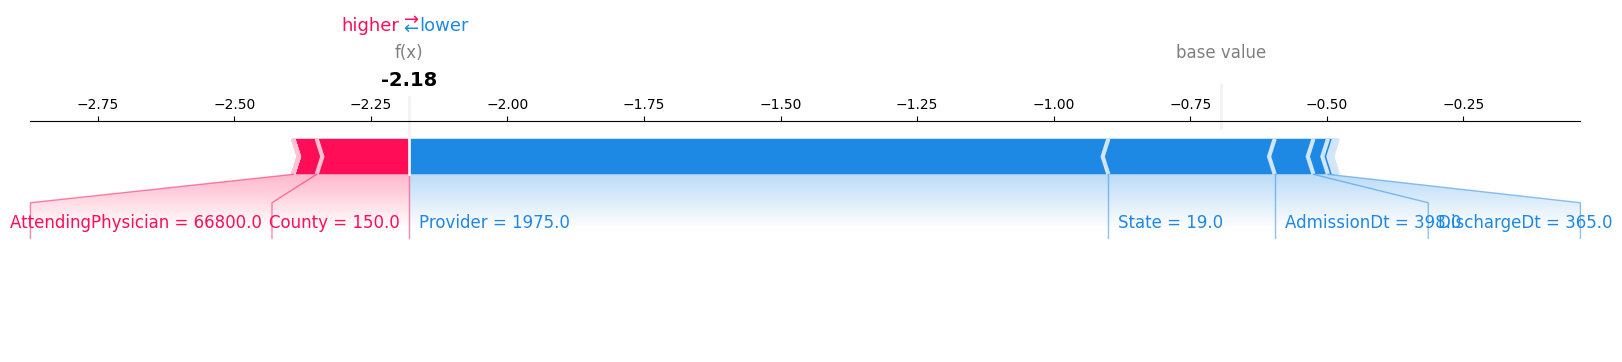

In [73]:
import shap
import matplotlib.pyplot as plt

# Ensure JS rendering
shap.initjs()

# Explain the first prediction (e.g., index 0)
i = 0
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[i],
    features=X_test.iloc[i],
    feature_names=X_test.columns,
    matplotlib=True
)

### SHAP Force Plot – Individual Prediction Breakdown
- Red bars push prediction higher (toward fraud).

- Blue bars push it lower (toward non-fraud).

- Length = strength of influence.

- This helps justify individual predictions — very useful for explainability in regulated sectors like healthcare.

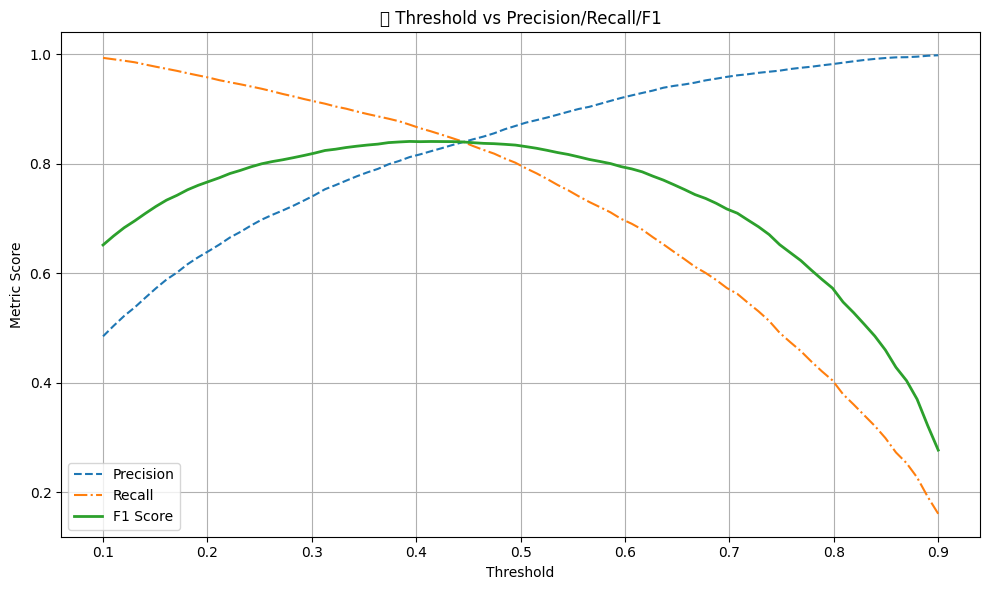

In [74]:
# Threshold Tuning Visualization – Optimize Precision/Recall/F1

from sklearn.metrics import precision_recall_fscore_support

# Get predicted probabilities from LightGBM model
y_probs = lgb_clf.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.1, 0.9, 80)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    preds = (y_probs >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

# 📈 Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', linestyle='-.')
plt.plot(thresholds, f1s, label='F1 Score', linewidth=2)
plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title("🎯 Threshold vs Precision/Recall/F1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Threshold Tuning Visualization – Optimize Precision/Recall/F1
- Helps decide the best threshold (not always 0.5).

- For example, choose a threshold with F1 peak, or prioritize high precision or recall.

- Crucial in healthcare fraud to reduce false positives (unnecessary investigation) or false negatives (missed fraud).



100%|===================| 139494/139553 [15:31<00:00]       

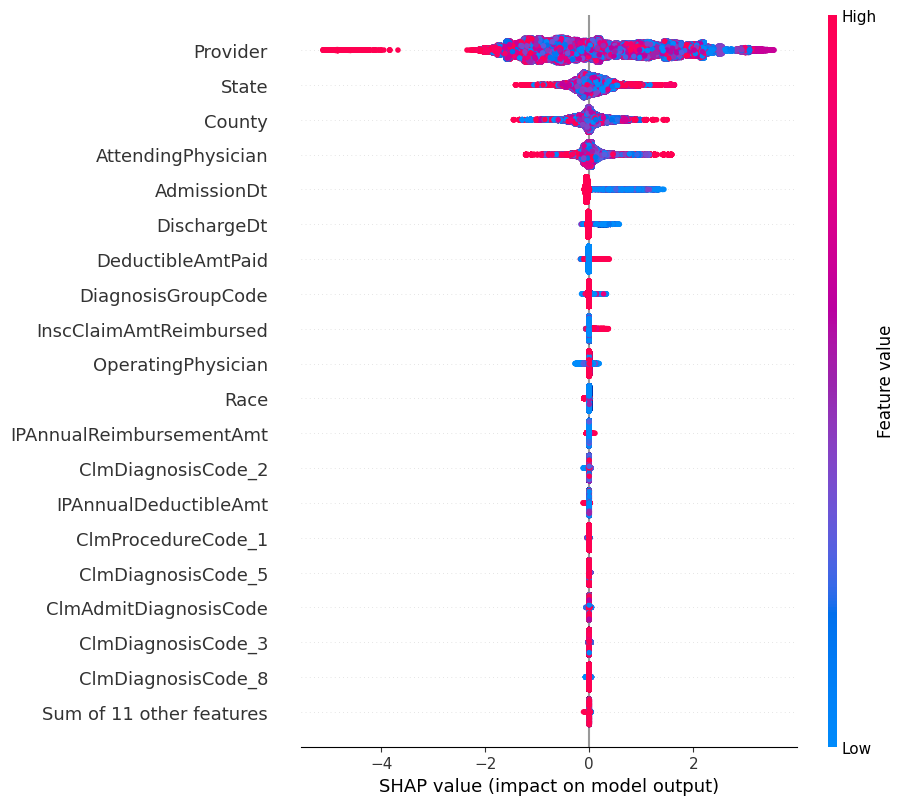

In [75]:
# SHAP Beeswarm Plot
# SHAP Beeswarm: shows top features and their direction (positive or negative impact)
explainer = shap.Explainer(lgb_clf, X_train, feature_names=X_train.columns)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values, max_display=20)


### SHAP Beeswarm Plot (more visual and directional than bar)
- Each dot on the plot represents a single row (patient claim) from the test set.
  - Y-axis: Top 20 most impactful features (ranked by SHAP value magnitude).

  - X-axis: SHAP value (how much that feature pushed the prediction towards fraud or not fraud).

Color:

🔴 Red = High feature value

🔵 Blue = Low feature value

So, for example:

If DeductibleAmtPaid is red and far to the right → high deductible strongly pushes prediction toward fraud.

If State is blue and far to the left → low state code pushes prediction toward non-fraud.

>
>  ✅ Why It Matters:

  - Helps auditors and stakeholders understand why a prediction is made.

  - Supports model trust and transparency, especially critical in healthcare fraud detection.

  - Uncovers non-obvious patterns, like:

      - Certain providers or counties consistently linked to fraud risk.

      - Specific admission codes associated with unusual patterns.

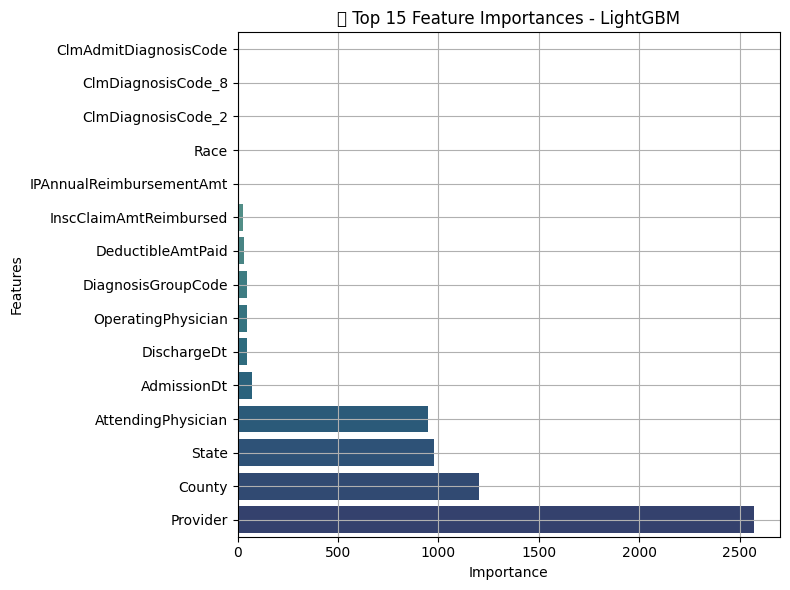

In [76]:
# Model-wise Feature Importance Bar Plots

# Function to plot top 15 features from any model
def plot_model_importance(model, model_name, feature_names, top_n=15):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='crest')
    plt.title(f"📊 Top {top_n} Feature Importances - {model_name}")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Example usage
plot_model_importance(lgb_clf, "LightGBM", X_train.columns)

### Model-wise Feature Importance Bar Plots
- This bar plot shows purely global importance based on how often and how usefully the feature is split on.
- The longer the bar, the more influence the feature has on model decisions.

100%|===================| 139456/139553 [13:14<00:00]       

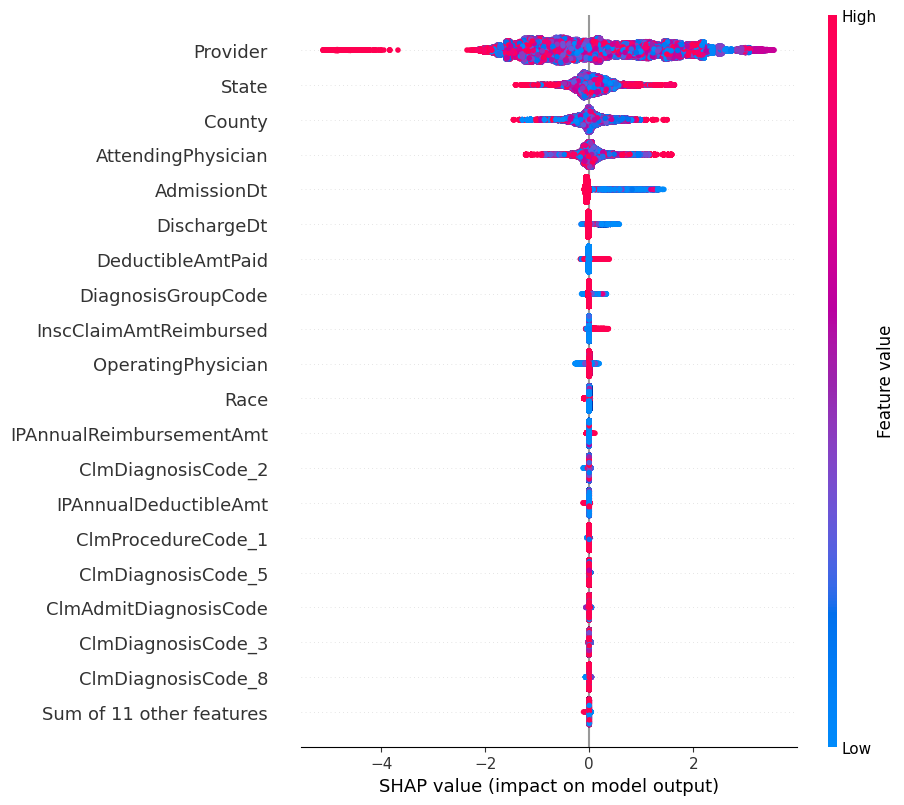

In [77]:
# SHAP Beeswarm Plot (LightGBM – Directional Impact)
import shap

# 🎯 Create SHAP explainer for LightGBM
explainer = shap.Explainer(lgb_clf, X_train, feature_names=X_train.columns)

# 💡 Compute SHAP values
shap_values = explainer(X_test)

# 📈 Plot beeswarm
shap.plots.beeswarm(shap_values, max_display=20)

### SHAP Beeswarm Plot (LightGBM – Directional Impact)
- Each dot = one row (claim).

- Color shows feature value (e.g., red = high, blue = low).

- X-axis shows impact (positive = more fraud-like, negative = not fraud).

- More powerful than the bar plot because it shows both importance + direction.

